In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix


In [2]:
df_label = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/UPDATED.csv', low_memory=False)
df_dme = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/mup_dme_ry21_p05_v10_dy19_prvhpr_0.csv', low_memory=False)
df_B = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formB_MUP_PHY_R21_P04_V10_D19_Prov_Svc.csv', encoding = "ISO-8859-1", low_memory=False)
df_D = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formD_MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv', encoding = "ISO-8859-1", low_memory=False)

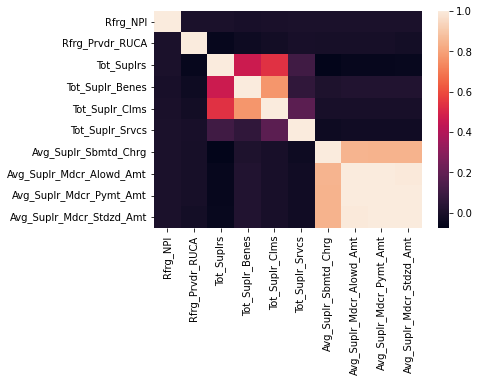

In [3]:
#drop the unneccessary columns obtained from EDA
sns.heatmap(df_dme.corr())
plt.show()
to_drop_dme = ['Avg_Suplr_Mdcr_Pymt_Amt', 'Avg_Suplr_Mdcr_Stdzd_Amt']
df_dme = df_dme.drop(labels = to_drop_dme, axis=1)

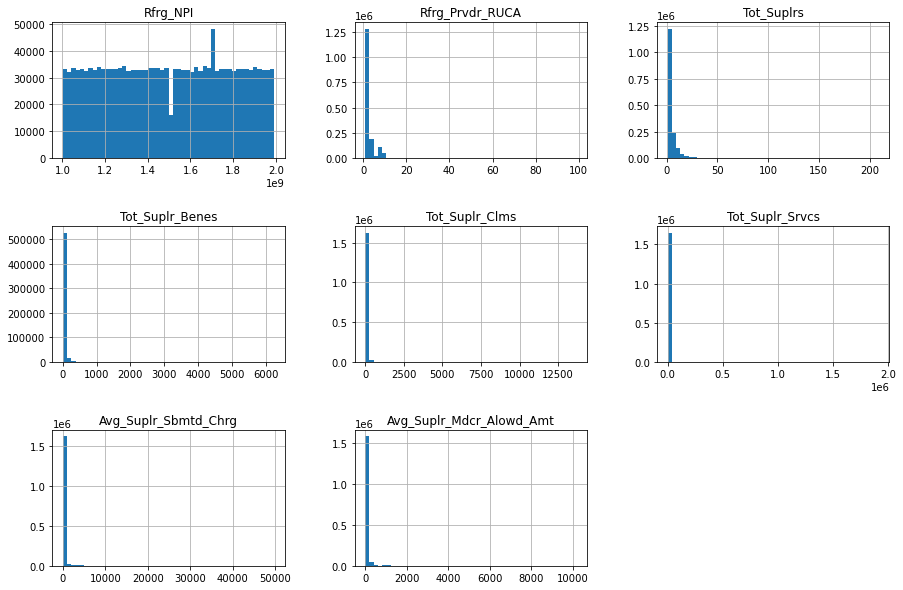

In [4]:
df_dme.hist(figsize = (15,10), bins = 50)
plt.subplots_adjust(hspace = 0.5)

In [5]:
from scipy import stats
def skew_transform(df, x):
    temp1 = np.log(df[x])
    temp2 = np.sqrt(df[x])
    temp3 = stats.boxcox(df[x])[0]
    v3 = pd.Series(temp3)
    temp1.hist(bins = 50, color = 'red')
    temp2.hist(bins = 50, color = 'tan')
    v3.hist(bins = 50, color = 'lime')
    print(pd.Series(temp1).skew())
    print(pd.Series(temp2).skew())
    print(pd.Series(temp3).skew())

0.439872628615546
1.8672761617663673
0.06161736749216321


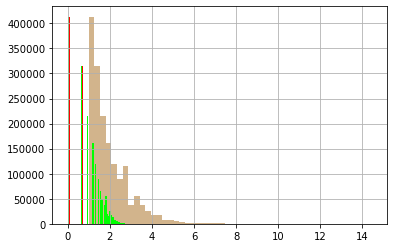

In [6]:
skew_transform(df_dme, 'Tot_Suplrs')
#choose 'boxcox'
df_dme['Tot_Suplrs'] = stats.boxcox(df_dme['Tot_Suplrs'])[0]

1.49759812822801
3.565014648826183
449.9899742094148


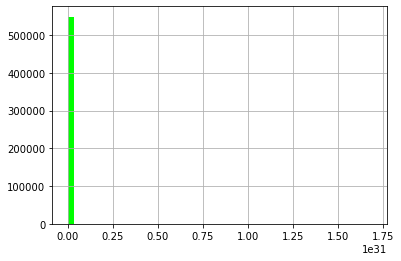

In [7]:
skew_transform(df_dme, 'Tot_Suplr_Benes')
#choose 'log'
df_dme['Tot_Suplr_Benes'] =np.log(df_dme['Tot_Suplr_Benes'])

1.4836267432996628
3.976032746526397
0.26593403096503965


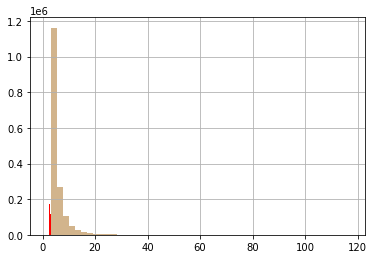

In [8]:
skew_transform(df_dme, 'Tot_Suplr_Clms')
#choose 'box_cox'
df_dme['Tot_Suplr_Clms'] = stats.boxcox(df_dme['Tot_Suplr_Clms'])[0]

1.2303800114460348
7.115511735878768
0.2939918992841499


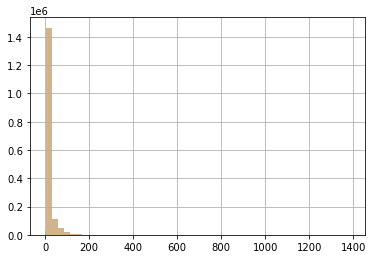

In [9]:
skew_transform(df_dme, 'Tot_Suplr_Srvcs')
#choose 'box_cox'
df_dme['Tot_Suplr_Srvcs'] = stats.boxcox(df_dme['Tot_Suplr_Srvcs'])[0]

-0.6735022819919168
3.1865233351733075
0.026537150149650482


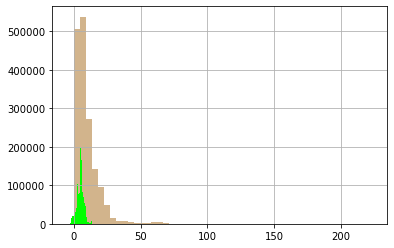

In [10]:
skew_transform(df_dme, 'Avg_Suplr_Sbmtd_Chrg')
#choose 'box_cox'
df_dme['Avg_Suplr_Sbmtd_Chrg'] = stats.boxcox(df_dme['Avg_Suplr_Sbmtd_Chrg'])[0]

-0.6535407997951659
3.9883706150239577
0.032564780427454046


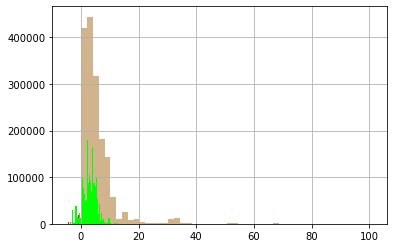

In [11]:
skew_transform(df_dme, 'Avg_Suplr_Mdcr_Alowd_Amt')
#choose 'box_cox'
df_dme['Avg_Suplr_Mdcr_Alowd_Amt'] = stats.boxcox(df_dme['Avg_Suplr_Mdcr_Alowd_Amt'])[0]

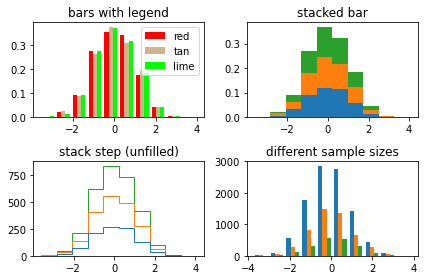

In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

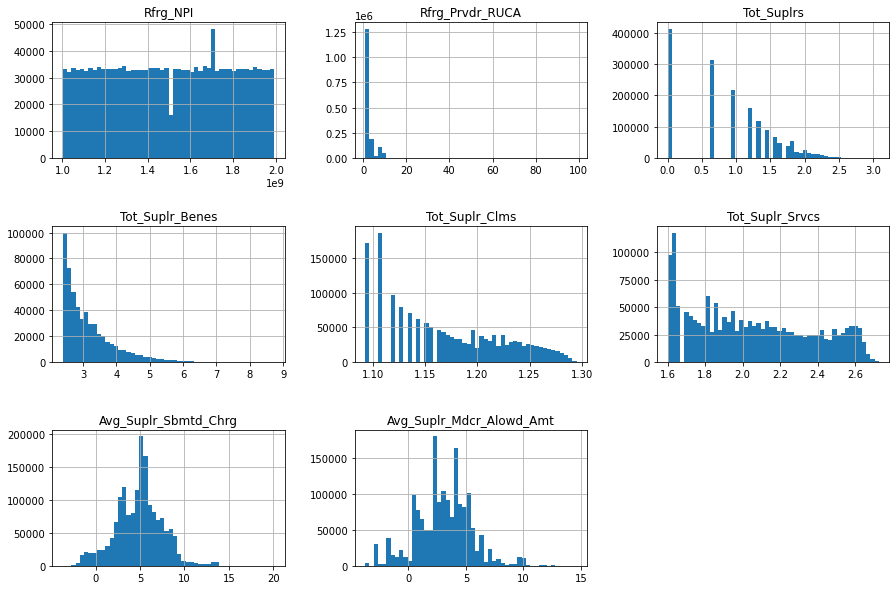

In [13]:
#check if skewness has been fixed
df_dme.hist(figsize = (15,10), bins = 50)
plt.subplots_adjust(hspace = 0.5)

In [14]:
#Build model
to_keep = ['Rfrg_NPI', 'Tot_Suplrs', 'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs', 'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt']
df_dme_num = df_dme[to_keep]

In [15]:
for i in df_dme_num.columns:
    print(i, df_dme_num[i].isnull().sum())

Rfrg_NPI 0
Tot_Suplrs 0
Tot_Suplr_Clms 0
Tot_Suplr_Srvcs 0
Avg_Suplr_Sbmtd_Chrg 0
Avg_Suplr_Mdcr_Alowd_Amt 0


In [20]:
#create fraud dataframe
df_label_fraud = df_label[df_label['NPI'] != 0]
label = df_label_fraud['NPI'].unique()
df_Potential_Fraud = {"NPI":[],"Potential_Fraud":[]}
for i in label:
    df_Potential_Fraud['NPI'].append(i) 
    df_Potential_Fraud['Potential_Fraud'].append('Yes')
df_Potential_Fraud = pd.DataFrame(df_Potential_Fraud)
df_Potential_Fraud

,NPI,Potential_Fraud
0,1972902351,Yes
1,1922348218,Yes
2,1942476080,Yes
3,1275600959,Yes
4,1891731758,Yes
...,...,...
6145,1053622035,Yes
6146,1124024435,Yes
6147,1194930149,Yes
6148,1578637385,Yes


In [31]:
#join fraud dataframe with df_dme_num
df_dme_num = df_dme_num.rename(columns={"Rfrg_NPI": "NPI"})
df_dme_num_label = df_dme_num.set_index('NPI').join(df_Potential_Fraud.set_index('NPI'), on = 'NPI', how = 'outer')
fraud_bool = df_dme_num_label['Potential_Fraud'] == 'Yes'
df_dme_num_label['Potential_Fraud_bool'] = fraud_bool
df_dme_num_label = df_dme_num_label[df_dme_num_label['Tot_Suplrs'].notna()]
df_dme_num_label = df_dme_num_label.drop(['NPI', 'Potential_Fraud'], axis = 1)
df_dme_num_label = df_dme_num_label.reset_index(drop=True)
df_dme_num_label
#df_dme_num_label.drop(['NPI', 'Potential_Fraud'])

,Tot_Suplrs,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Potential_Fraud_bool
0,1.346344,1.246641,2.156386,4.901141,3.638665,False
1,1.346344,1.255096,2.206062,8.152509,6.137773,False
2,2.018485,1.237194,2.279676,5.146584,2.348463,False
3,0.640973,1.116936,1.665874,3.055014,1.305781,False
4,1.654676,1.176695,1.948658,3.002835,0.368023,False
...,...,...,...,...,...,...
1656444,2.584792,1.283582,2.483023,8.959817,8.289864,True
1656445,2.651148,1.288874,2.537449,6.428773,5.882682,True
1656446,2.457440,1.280071,2.451572,5.240443,4.739485,True
1656447,2.576519,1.281280,2.442075,9.000862,8.345924,True


In [38]:
data_quantity = df_dme_num_label[df_dme_num_label.columns[:-1]]
label_quantity = df_dme_num_label[df_dme_num_label.columns[-1]]

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [45]:
state_summary_scale = scale(data_quantity)
state_pca = PCA().fit(state_summary_scale)
state_pca_x = state_pca.transform(state_summary_scale)


In [46]:
state_pca.explained_variance_ratio_.cumsum()

array([0.49712092, 0.82300618, 0.93825679, 0.98556631, 1.        ])

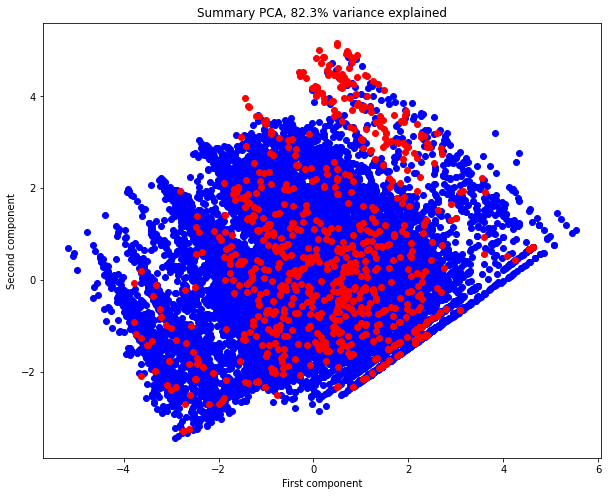

In [63]:
x = state_pca_x[:, 0]
y = state_pca_x[:, 1]
pc_var = 100*state_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x[:20000], y=y[:20000], c='b') #label_quantity[:9], cmap=plt.cm.autumn)
#plt.scatter(x=x[-9:], y=y[-9:], c='r')#label_quantity[-100:], cmap=plt.cm.spring)
plt.scatter(x=x[label_quantity == True], y=y[label_quantity == True], c='r')#label_quantity[-100:], cmap=plt.cm.spring)

plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Summary PCA, {pc_var:.1f}% variance explained')
# for s, x, y in zip(state, x, y):
#     plt.annotate(s, (x, y))
plt.show()

In [70]:
!pip install statsmodels

     |████████████████████████████████| 9.6 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 19.1 MB/s eta 0:00:01


In [71]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import statsmodels.api as sm
import statsmodels.formula.api as sfm

from matplotlib.widgets import Slider, Button, RadioButtons
from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols


from IPython.display import display_html

In [124]:
#split the data set
data_fraud = df_dme_num_label[df_dme_num_label['Potential_Fraud_bool'] == True]
data_non_fraud = df_dme_num_label[df_dme_num_label['Potential_Fraud_bool'] == False]
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(data_fraud.drop(columns='Potential_Fraud_bool'), 
                                                    data_fraud.Potential_Fraud_bool, test_size=0.3, 
                                                    random_state=47)
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(data_non_fraud.drop(columns='Potential_Fraud_bool'), 
                                                    data_non_fraud.Potential_Fraud_bool, test_size=0.3, 
                                                    random_state=47)
x_train = pd.concat([x_train_f, x_train_n])
x_test = pd.concat([x_test_f, x_test_n])
y_train = pd.concat([y_train_f, y_train_n])
y_test = pd.concat([y_test_f, y_test_n])

In [90]:
#pure logistic regression
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [91]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression()

In [92]:
y_pred = classifier.predict(x_test) 
y_pred

array([False, False, False, ..., False, False, False])

In [93]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.9995472244860998


In [96]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[496710,      0],
       [   225,      0]])

In [128]:
#let's try undersampling
data_fraud = df_dme_num_label[df_dme_num_label['Potential_Fraud_bool'] == True]
data_non_fraud = df_dme_num_label[df_dme_num_label['Potential_Fraud_bool'] == False]
x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(data_fraud.drop(columns='Potential_Fraud_bool'), 
                                                    data_fraud.Potential_Fraud_bool, test_size=0.3, 
                                                    random_state=47)
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(data_non_fraud.drop(columns='Potential_Fraud_bool'), 
                                                    data_non_fraud.Potential_Fraud_bool, test_size=0.3, 
                                                    random_state=47)
x_train = pd.concat([x_train_f, x_train_n[0:len(x_train_f)]])
x_test = pd.concat([x_test_f, x_test_n[0:len(x_test_f)]])
y_train = pd.concat([y_train_f, y_train_n[0:len(y_train_f)]])
y_test = pd.concat([y_test_f, y_test_n[0:len(y_test_f)]])


In [98]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [99]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression()

In [100]:
y_pred = classifier.predict(x_test) 
y_pred

array([False,  True, False, False, False,  True,  True,  True,  True,
       False, False, False, False,  True, False,  True, False,  True,
       False, False, False,  True,  True,  True,  True, False,  True,
       False, False,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True, False, False,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
        True, False,  True,  True,  True, False,  True,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True,  True, False,  True, False,  True, False,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True, False, False,  True, False, False,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
       False, False,

In [101]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[155,  70],
       [127,  98]])

In [103]:
!pip install xgboost

     |████████████████████████████████| 1.7 MB 4.5 MB/s eta 0:00:01


In [113]:
#try xgboost
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

In [129]:
xgbr = xgb.XGBClassifier() 
xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_test)
metrics.confusion_matrix(y_test, y_pred)


array([[139,  86],
       [ 97, 128]])

In [106]:
#try random forest 


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [112]:
y_pred = xgbr.predict(x_test)


[ 2.92811871e-01  9.24545407e-01  2.28042260e-01  5.13323307e-01
  3.94640714e-01  1.11594462e+00  7.74933398e-01  1.01532805e+00
  9.34905291e-01  2.85216123e-01  6.61377490e-01  3.19303066e-01
  4.85712647e-01  5.92105865e-01  9.76897001e-01  1.11268890e+00
  6.43560588e-01  3.75594407e-01  1.60732165e-01  2.50642687e-01
  3.81961465e-01  1.02156115e+00  5.61049938e-01  9.87277508e-01
  1.02571380e+00  8.57915953e-02  1.02366567e+00  4.81593549e-01
  4.83465731e-01  4.20087427e-01  4.83799070e-01  4.28823978e-01
  5.37074327e-01  5.23227546e-03  6.25920951e-01  2.20604494e-01
  4.34966415e-01  7.12540209e-01  7.90389836e-01  9.94500875e-01
  2.47591332e-01  5.98209381e-01  8.81394565e-01  3.01715463e-01
  1.12891448e+00  4.29644883e-01  2.69789696e-01  9.97215569e-01
  5.80578923e-01  4.10503298e-01  3.74124527e-01  9.95819569e-01
  2.17126850e-02  5.52769780e-01  6.32090926e-01 -1.50352508e-01
  2.41217941e-01  6.39129758e-01  8.31247211e-01  4.02047932e-01
  3.54581088e-01  9.81648

In [86]:
df_train_f, df_test_f = train_test_split(data_fraud, test_size=0.3, 
                                                    random_state=47)
df_train_n, df_test_n = train_test_split(data_non_fraud, test_size=0.3, 
                                                    random_state=47)
df_train = pd.concat([df_train_f, df_train_n])
df_test = pd.concat([df_test_f, df_test_n])
x_test = df_test.drop(columns = 'Potential_Fraud_bool')
y_test = df_test['Potential_Fraud_bool']

In [ ]:
#let's try one hot encoding of categorical variables
dmepos_category_columns = ['REFERRING_PROVIDER_GENDER', 'REFERRING_PROVIDER_TYPE']
dmepos = pd.get_dummies(dmepos, columns=dmepos_category_columns, drop_first=True)